In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
import math
from astroNN.nn.layers import MCDropout
import math
from matplotlib.ticker import FormatStrFormatter

In [2]:

syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov), np.min(np.abs(syscov)))

-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31) 1.695011341e-07


In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

In [4]:

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = 10**orderMag(matrix[row, col])
    return magMatrix
            
            

In [5]:
def matrixGenerator(omatrix, nmatrix, freq_original=100, noise_factor=1):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        print("Generating matrix {}".format(it+1), end='\r')
        mag = matrixMag(omatrix)
        m = omatrix + np.multiply(noise_factor*np.random.randn(nsize,nsize), mag)       
        matrixset[it, :, :] = m
        
    return matrixset
def matrixGenerator2(omatrix, nmatrix, freq_original=100):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        print("Generating matrix {}".format(it+1), end='\r')
        if it % freq_original ==0:
            m = omatrix
        else:
            m = P@omatrix@P.T
       
        mag = matrixMag(omatrix)
        
        matrixset[it, :, :] = m + np.multiply(0.1*np.random.rand(nsize,nsize), mag)
        

    return matrixset

### Generate a data set with covariance matrix from the original plus gaussian noise

In [6]:
numMatrix = 2000
# covset, D = matrixGenerator3(syscov, numMatrix)
covset = matrixGenerator(syscov, numMatrix, noise_factor=2)
# covset_noise = matrixGenerator(syscov, numMatrix, noise_factor=10)

(2000, 31, 31) 4.573229323638062e-11


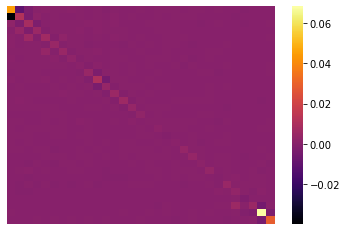

In [7]:
print(np.shape(covset), np.min(np.abs(covset)))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
# covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(covset_test[5,:,:], 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
# covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
# covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



## Here starts the VAE network

- Original input is the data len for JLA compilation-
- We try with 3 hidden layer
- We want that the latent space has 1 dimension to make a mapping with the redshift

In [275]:
original_dim = nsize*nsize
intermediate_dim1 = 150
intermediate_dim2 = 100
intermediate_dim3 = 50
intermediate_dim4 = 50

latent_dim = 1
actfn = 'tanh'


inputs = tf.keras.Input(shape=(original_dim))
h = layers.Dense(intermediate_dim1, activation=actfn)(inputs)
h = layers.Dense(intermediate_dim2, activation=actfn)(h)
h = layers.Dense(intermediate_dim3, activation=actfn)(h)
h = layers.Dense(intermediate_dim4, activation=actfn)(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


In [276]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.0, stddev=0.05)
                              #                               mean=0.0, stddev=0.05)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [277]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])
# z = Sampling()([z_mean, z_log_sigma])
# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 961)]        0                                            
__________________________________________________________________________________________________
dense_132 (Dense)               (None, 150)          144300      input_13[0][0]                   
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 100)          15100       dense_132[0][0]                  
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 50)           5050        dense_133[0][0]                  
____________________________________________________________________________________________

In [278]:


# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim4, activation=actfn)(latent_inputs)
x = layers.Dense(intermediate_dim3, activation=actfn)(x)
x = layers.Dense(intermediate_dim2, activation=actfn)(x)
x = layers.Dense(intermediate_dim1, activation=actfn)(x)
outputs = layers.Dense(original_dim, activation='linear')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')


In [279]:
# reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
# reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -5*1e-10 #a partir de 1e-5 mejora. 1e-8 y 1e-10 los mejores, después empeora, funciona 1e-13
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [280]:
vae_train = vae.fit(covset_train, covset_train,
                    epochs=200,
                    batch_size=16,
                    shuffle=True,
                    validation_data=(covset_test, covset_test))

Epoch 1/200
100/100 [==============================] - 1s 3ms/step - loss: 9.3328e-06 - val_loss: 2.8286e-06
Epoch 2/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7992e-06 - val_loss: 2.7658e-06
Epoch 3/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7794e-06 - val_loss: 2.7557e-06
Epoch 4/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7702e-06 - val_loss: 2.7590e-06
Epoch 5/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7686e-06 - val_loss: 2.7304e-06
Epoch 6/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7827e-06 - val_loss: 2.7263e-06
Epoch 7/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7264e-06 - val_loss: 2.7089e-06
Epoch 8/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7404e-06 - val_loss: 2.7664e-06
Epoch 9/200
100/100 [==============================] - 0s 2ms/step - loss: 2.7641e-06 - val_loss: 2.7712e-06
Epoch 10/200
100/10

100/100 [==============================] - 0s 2ms/step - loss: 2.3113e-06 - val_loss: 2.3636e-06
Epoch 76/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3447e-06 - val_loss: 2.3475e-06
Epoch 77/200
100/100 [==============================] - 0s 2ms/step - loss: 2.2863e-06 - val_loss: 2.3389e-06
Epoch 78/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3191e-06 - val_loss: 2.3383e-06
Epoch 79/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3084e-06 - val_loss: 2.3229e-06
Epoch 80/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3057e-06 - val_loss: 2.3542e-06
Epoch 81/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3348e-06 - val_loss: 2.3434e-06
Epoch 82/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3056e-06 - val_loss: 2.3195e-06
Epoch 83/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3205e-06 - val_loss: 2.3265e-06
Epoch 84/200
100/100 [=

100/100 [==============================] - 0s 2ms/step - loss: 2.3198e-06 - val_loss: 2.3074e-06
Epoch 150/200
100/100 [==============================] - 0s 2ms/step - loss: 2.2868e-06 - val_loss: 2.3204e-06
Epoch 151/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3287e-06 - val_loss: 2.3308e-06
Epoch 152/200
100/100 [==============================] - 0s 2ms/step - loss: 2.2709e-06 - val_loss: 2.3173e-06
Epoch 153/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3291e-06 - val_loss: 2.3206e-06
Epoch 154/200
100/100 [==============================] - 0s 2ms/step - loss: 2.2921e-06 - val_loss: 2.3066e-06
Epoch 155/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3093e-06 - val_loss: 2.3360e-06
Epoch 156/200
100/100 [==============================] - 0s 2ms/step - loss: 2.3199e-06 - val_loss: 2.3594e-06
Epoch 157/200
100/100 [==============================] - 0s 2ms/step - loss: 2.2947e-06 - val_loss: 2.3131e-06
Epoch 158/200
1

In [281]:
# Guardar modelos
# vae.save('../models/autoencoderJLA.h5')
# vae.save('../models/decoderJLA.h5')
# vae.save('../models/encoderJLA.h5')

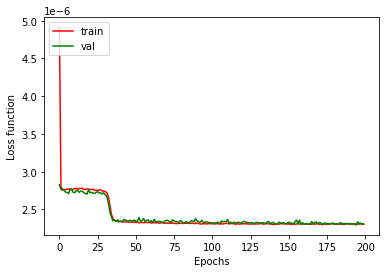

In [282]:
plt.plot(vae_train.history['loss'], color='r')
plt.plot(vae_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('Loss function')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

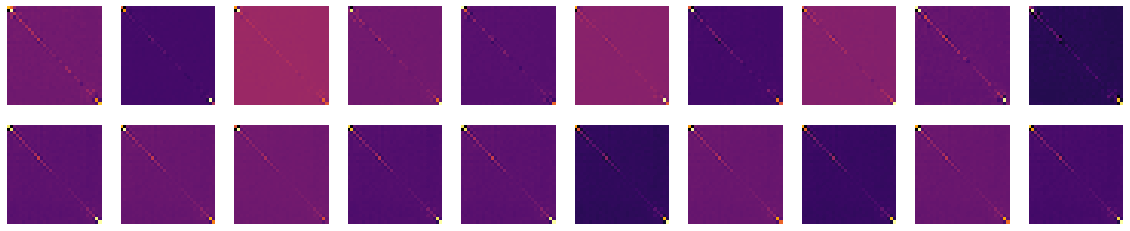

In [283]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs[2])

n = 10  # How many figures we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
   
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

In [284]:
x_test_encoded = encoder.predict(covset_test)
z_mean = x_test_encoded[0]
z_std = x_test_encoded[1]
z_latent = x_test_encoded[2]

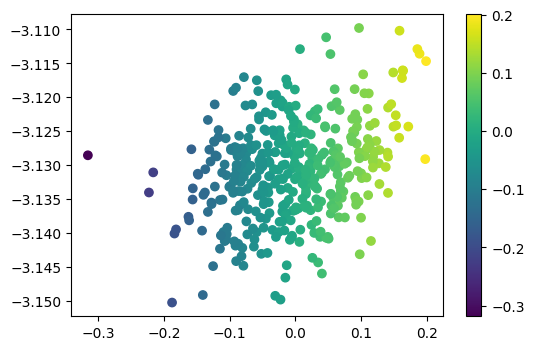

In [285]:
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(z_mean, z_std, c=z_latent)
plt.colorbar()


<Figure size 1080x1080 with 0 Axes>

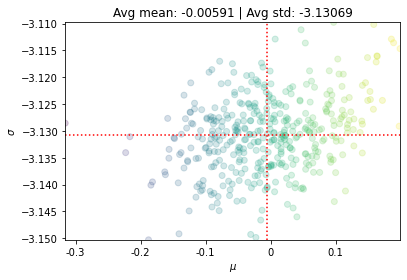

In [286]:
plt.figure(figsize=(15, 15))
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.scatter(z_mean, z_std, marker='o', c=z_latent, alpha=0.2)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
meanmean = np.mean(z_mean)
meanstd = np.mean(z_std)
plt.title('Avg mean: {:.5f} | Avg std: {:.5f}'.format(meanmean, meanstd))
xmin = np.min(z_mean)#-0.1*10**orderMag(meanmean)
xmax = np.max(z_mean)#+0.1*10**orderMag(meanmean)
ymin = np.min(z_std)#-0.1*10**orderMag(meanmean)
ymax = np.max(z_std)#+0.1*10**orderMag(meanmean)
# ax.xaxis.set_ticks(np.arange(xmin, xmax, 1e-10))
# plt.colorbar()

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.xticks()
plt.hlines(meanstd, xmin, xmax, colors='r', linestyles='dotted')
plt.vlines(meanmean, ymin, ymax, colors='r', linestyles='dotted')
plt.show()

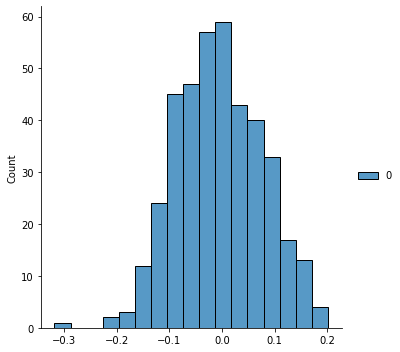

In [287]:
sns.displot(z_latent)

In [288]:
clean_matrix = vae.predict(covset_test[10,:].reshape(-1,31*31))

<AxesSubplot:>

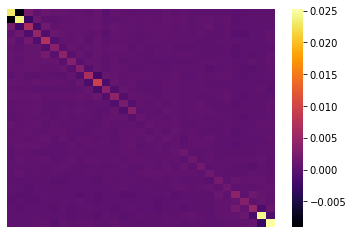

In [289]:
sns.heatmap(clean_matrix.reshape(31,31), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

# Test with syscov

In [290]:
ztest2 = encoder.predict(syscov.reshape((-1,31*31)))
z_mean_syscov, z_std_syscov, z_sample_syscov = ztest2
# z_sample_syscov, mean_latent
z_mean_syscov, z_std_syscov, z_sample_syscov

(array([[-0.00386001]], dtype=float32),
 array([[-3.1314301]], dtype=float32),
 array([[-0.00111266]], dtype=float32))

<AxesSubplot:>

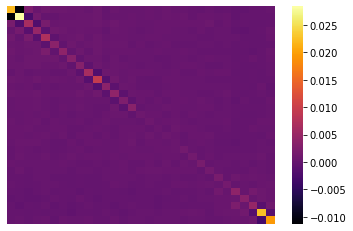

In [291]:
vec = np.array(z_sample_syscov)
decm = decoder.predict(vec)
sns.heatmap(decm.reshape(31,31), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', cbar=True,
            robust=False)

# Loading FFNN predictions

In [269]:
# ranz = np.random.uniform(0, 1.3, (nsize,))
ranz = np.linspace(0.01, 1.3, 31)
# ranz = z_redshift + 0.001*np.random.randn()
ranz

array([0.01 , 0.053, 0.096, 0.139, 0.182, 0.225, 0.268, 0.311, 0.354,
       0.397, 0.44 , 0.483, 0.526, 0.569, 0.612, 0.655, 0.698, 0.741,
       0.784, 0.827, 0.87 , 0.913, 0.956, 0.999, 1.042, 1.085, 1.128,
       1.171, 1.214, 1.257, 1.3  ])

In [270]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA.h5')
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


index = np.argsort(ranz)
ranz = ranz[index]
# ranz= z

pred_random = ffnn.predict(np.log(ranz))
pred_dl = pred_random[:,0].reshape(-1,1)

# pred_dl_sc = scalerdist.transform(pred_dl)
pred_dl_sc = pred_dl.reshape(31,)[index]
pred_err = np.exp(pred_random[:,1][index].reshape(-1,1))
dlfake = scalerdist.inverse_transform(pred_dl.reshape(31,)[index])

fake_data = np.stack((ranz[index], dlfake[index]), axis=1)

np.savetxt("fake_binned_JLA2TEST3XTREME.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

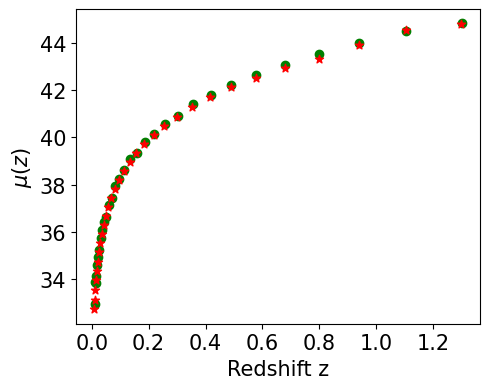

In [271]:
data = np.loadtxt("fake_binned_JLA2TEST3new.dat")
ranz = data[:,0]
dlfake = data[:,1]
plt.figure(figsize=(5,4), dpi=100)
# plt.errorbar(ranz, pred_random, yerr=0, fmt='r.', markersize=10.)
# plt.scatter(z, dl)
plt.scatter(z_redshift, dist,c='g', label='Observations')
plt.scatter(ranz, dlfake, c='r', label='Synthetic data', marker='*')


# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

In [272]:
# pred_dl
mean_ref = np.mean(dist)
std_ref = np.std(dist)
mean_pred = np.mean(dlfake)
std_pred = np.std(dlfake)
# delta_mean = z_mean_syscov - mean_ref
delta_mean = z_sample_syscov - mean_ref


mean_ref, delta_mean, z_mean_syscov

(38.762822546580644,
 array([[-38.764515]], dtype=float32),
 array([[-0.00076206]], dtype=float32))

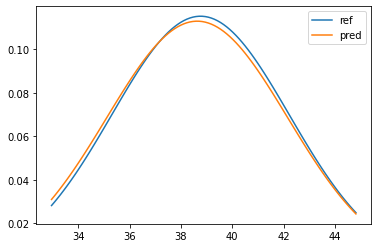

In [273]:
xmin = np.min(dist)
xmax= np.max(dist)
x = np.linspace(xmin, xmax, 100)
y1 = sp.stats.norm.pdf(x, mean_ref, std_ref)


# x = np.linspace(xmin, xmax, 100)
y2 = sp.stats.norm.pdf(x, mean_pred, std_pred)
plt.plot(x, y1, label='ref')
plt.plot(x, y2, label='pred')

# plt.show()
# dist_sc
plt.legend()

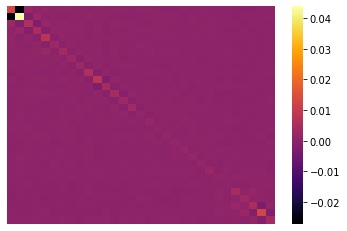

In [274]:
z_sample = np.array([mean_pred+delta_mean])

newmatrix = decoder.predict(z_sample)
# newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
newmatrixr = newmatrix.reshape(31,31)
# newmatrixr = newmatrixr@D@newmatrixr.T
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

np.savetxt("fake_binned_JLA_COVdecodedTEST3vae.dat", newmatrixr, delimiter= " ", header="#fake COV")